## Clustering with K-Means

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

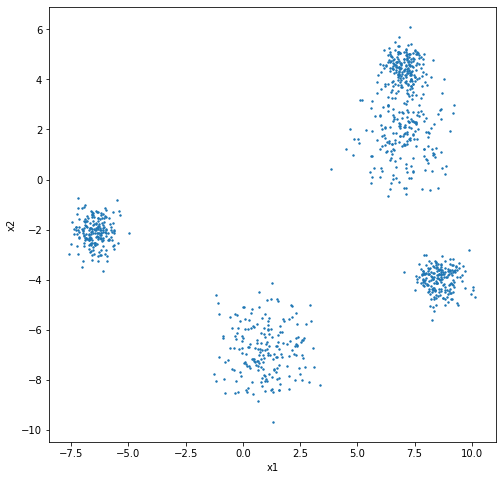

In [3]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [4]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [5]:
y_pred is kmeans.labels_

True

In [6]:
# 5 centroids found
kmeans.cluster_centers_

array([[ 7.00650848,  1.50746152],
       [ 0.95560345, -6.79720513],
       [-6.46299475, -2.09759078],
       [ 8.59614697, -3.98309806],
       [ 7.02424648,  4.33704137]])

In [7]:
import numpy as np
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [8]:
kmeans.predict(X_new)

array([0, 0, 2, 2])

In [9]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [10]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

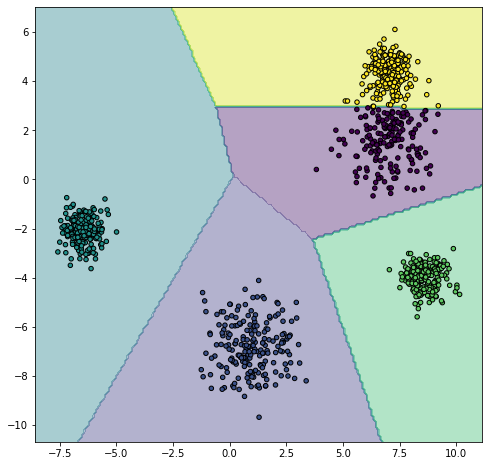

In [11]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, edgecolor='k')
plt.show()

In [12]:
# distance from each instance to every centroid
kmeans.transform(X_new)

array([[ 7.0237992 ,  8.84895452,  7.65248661, 10.47335692,  7.40282385],
       [ 4.03666995,  9.03163193, 10.31205701,  8.1923332 ,  4.65363536],
       [10.11720727, 10.56560585,  6.16261019, 13.53640584, 10.11302116],
       [10.05561259, 10.10370338,  5.75588165, 13.28537486, 10.19118435]])

In [13]:
# when you know where the centroids are
good_init = np.array([[-3,3], [-3,2], [-3,1], [-1,2], [0,2]])
kmeans = KMeans(n_clusters=5, init = good_init, n_init=1)

#### Accelerated K-Means anda Mini-Batch K-Means

In [14]:
from sklearn.cluster import MiniBatchKMeans

In [15]:
minibatch_kmeans = MiniBatchKMeans(n_clusters = 5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [16]:
#performance measure
from sklearn.metrics import silhouette_score
silhouette_score(X, minibatch_kmeans.labels_)

0.7232929051938809

In [17]:
scores = list()
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scores.append(silhouette_score(X, kmeans.labels_))
    del(kmeans)

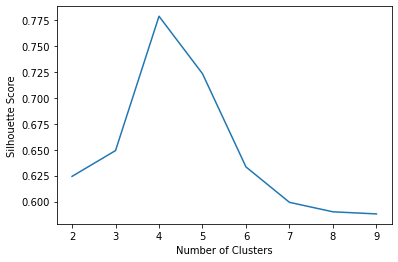

In [18]:
plt.plot(list(range(2, 10)), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show() #five cluster is the best choice

### Using Clustering for Image Segmentation

In [19]:
from matplotlib.image import imread
import os

In [20]:
image = imread(os.path.join("images", "unsupervised_learning", "ladybug.png"))

In [21]:
image.shape

(533, 800, 3)

In [22]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [23]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

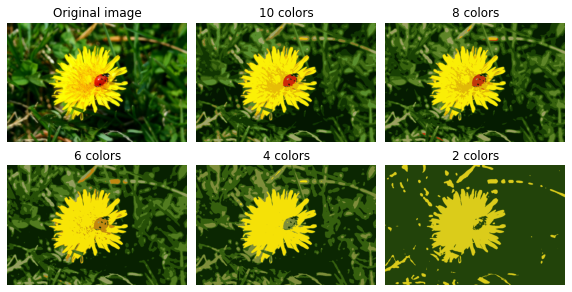

In [24]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

### Clustering for Preprocessing
- dimensionality reduction

In [25]:
from sklearn.datasets import load_digits

In [26]:
X_digits, y_digits = load_digits(return_X_y= True)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [28]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [29]:
log_reg.score(X_test, y_test)

0.9577777777777777

In [30]:
# adding a preprocessing step(clustering)
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(solver='liblinear', multi_class='auto'))
])

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression(solver='liblinear'))])

In [32]:
pipeline.score(X_test, y_test)

0.9777777777777777

We can use GridSearchCV to find the optimal number of clusters based on the final scoring by Logistic Regression

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
param_dict = dict(kmeans__n_clusters=range(50,125))

In [35]:
grid_clf = GridSearchCV(pipeline, param_dict, cv=3, verbose=2)

In [36]:
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END ..............................kmeans__n_clusters=50; total time=   0.4s
[CV] END ..............................kmeans__n_clusters=50; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=50; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=51; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=51; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=51; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=52; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=52; total time=   0.5s
[CV] END ..............................kmeans__n_clusters=52; total time=   0.6s
[CV] END ..............................kmeans__n_clusters=53; total time=   0.6s
[CV] END ..............................kmeans__n_clusters=53; total time=   0.5s
[CV] END ..............................kmeans__

[CV] END ..............................kmeans__n_clusters=83; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=84; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=84; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=84; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=85; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=85; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=85; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=86; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=86; total time=   0.9s
[CV] END ..............................kmeans__n_clusters=86; total time=   0.9s
[CV] END ..............................kmeans__n_clusters=87; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=87; total time=   0.8s
[CV] END ...................

[CV] END .............................kmeans__n_clusters=117; total time=   1.0s
[CV] END .............................kmeans__n_clusters=118; total time=   1.0s
[CV] END .............................kmeans__n_clusters=118; total time=   1.0s
[CV] END .............................kmeans__n_clusters=118; total time=   1.0s
[CV] END .............................kmeans__n_clusters=119; total time=   1.1s
[CV] END .............................kmeans__n_clusters=119; total time=   1.0s
[CV] END .............................kmeans__n_clusters=119; total time=   1.0s
[CV] END .............................kmeans__n_clusters=120; total time=   1.0s
[CV] END .............................kmeans__n_clusters=120; total time=   1.2s
[CV] END .............................kmeans__n_clusters=120; total time=   1.1s
[CV] END .............................kmeans__n_clusters=121; total time=   1.0s
[CV] END .............................kmeans__n_clusters=121; total time=   1.0s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'kmeans__n_clusters': range(50, 125)}, verbose=2)

In [37]:
grid_clf.best_params_

{'kmeans__n_clusters': 116}

In [38]:
grid_clf.score(X_test, y_test)

0.9777777777777777

### Clustering for Semi-Supervised Learning

In [39]:
n_labeled = 50

In [40]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [41]:
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(solver='liblinear')

In [42]:
log_reg.score(X_test, y_test)

0.86

In [43]:
# cluster the training setinto 50 cluster (one image per cluster)
k = 50
kmeans = KMeans(n_clusters=k)

X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

In [44]:
#manually labeling the instances 
y_representative_digits = y_train[representative_digit_idx].copy()

In [45]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [46]:
log_reg.fit(X_representative_digits, y_representative_digits)

LogisticRegression(solver='liblinear')

In [47]:
log_reg.score(X_test, y_test)

0.8911111111111111

Label Propagation

In [48]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

In [49]:
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [50]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [51]:
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(solver='liblinear')

In [52]:
log_reg.score(X_test, y_test)

0.9155555555555556

 - only propagate the labels to the 20% of the instances that are closest to the centroids

In [53]:
percentile_closest = 20.
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

In [54]:
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [55]:
partially_propagated = (X_cluster_dist != -1)

In [56]:
X_train_partially_propagated = X_train[partially_propagated]

In [57]:
y_train_partially_propagated = y_train[partially_propagated]

In [58]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [59]:
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(solver='liblinear')

In [60]:
log_reg.score(X_test, y_test)

0.9088888888888889

## DBSCAN

In [61]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise= 0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)

In [62]:
dbscan.fit(X)

DBSCAN(eps=0.05)

In [63]:
dbscan.labels_

array([ 0,  1,  2,  2,  0,  1,  0,  2,  2,  0,  3,  2,  2,  1,  2,  0,  4,
        2,  0,  5,  4,  0, -1,  0,  3,  4,  2,  3, -1,  2,  0,  2,  3,  5,
        3,  3,  1,  2,  3,  5,  1,  0,  3,  3,  5,  4,  2, -1, -1,  2,  0,
        4,  0,  1,  0,  4,  6,  0,  0,  4,  0,  0,  0,  3,  4,  5,  1,  0,
        3,  2,  4,  2,  0,  3,  3, -1,  3,  2,  2,  4,  2, -1,  0,  2,  4,
       -1,  2,  3,  3,  0,  2,  2,  5,  4,  1,  2,  2,  2,  2,  1,  5,  2,
        3,  0,  3,  1,  4,  1,  2,  3,  3,  3,  2,  2,  0,  5,  0,  5,  0,
        2,  0,  0,  1,  2,  0,  4,  3,  1,  1,  0,  5,  3,  4,  2,  1,  1,
        1,  3,  4,  4,  3,  2,  2,  3,  0,  4,  3,  4,  0,  0,  0,  2,  2,
        3,  3,  1,  3,  2, -1,  4,  0,  0,  2,  2,  2,  4,  1,  3,  5,  2,
        3,  2,  4,  2,  1,  4,  0,  4, -1,  5, -1,  4,  3,  3,  2,  2,  2,
        4,  2,  4,  3,  0,  4,  2,  2,  0,  2,  2,  3,  2,  1,  0,  4,  3,
        1,  4,  2,  5,  4,  1,  0,  4,  3,  2,  1, -1,  4,  2,  2,  2,  2,
        0, -1,  3,  2,  2

In [64]:
len(dbscan.core_sample_indices_)

812

In [65]:
# actual core instances coords
dbscan.components_

array([[ 0.83791763, -0.53589431],
       [ 0.48982307, -0.35086042],
       [-0.14048295,  1.04764327],
       ...,
       [ 1.04872844,  0.09036567],
       [ 1.86980557, -0.09999226],
       [-0.39088686,  0.83691058]])

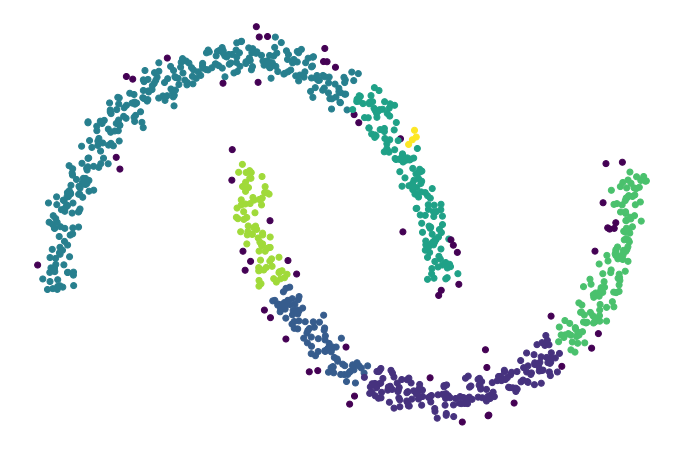

In [66]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_)
plt.axis('off')
plt.show()

In [67]:
# increasing epsilon
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.2)

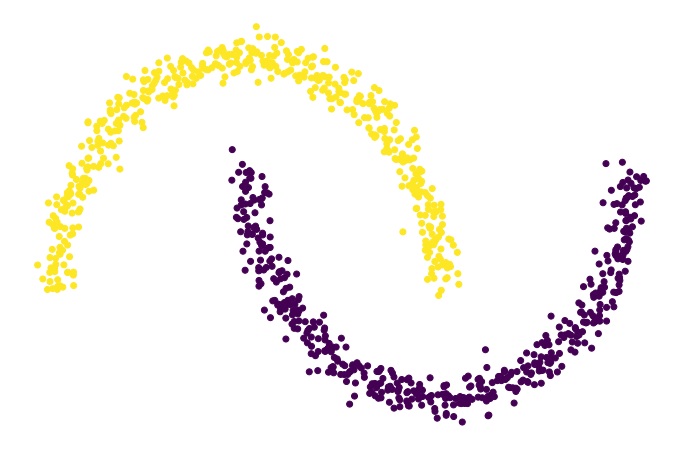

In [68]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_)
plt.axis('off')
plt.show()

In [69]:
#implementing a predict() method
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [70]:
X_new = np.array([[-0.5, 0.], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [71]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.14, 0.86],
       [1.  , 0.  ]])

In [72]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

# Gaussian Mixture Model

In [73]:
from sklearn.mixture import GaussianMixture

In [74]:
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [75]:
gm.weights_

array([0.59768528, 0.20068876, 0.20162596])

In [76]:
gm.means_

array([[ 0.50021654,  0.25149588],
       [-0.74910308,  0.55358556],
       [ 1.74923812, -0.05271275]])

In [77]:
gm.covariances_

array([[[ 0.17399566, -0.1098369 ],
        [-0.1098369 ,  0.29013246]],

       [[ 0.05184528,  0.0613228 ],
        [ 0.0613228 ,  0.08900057]],

       [[ 0.05144906,  0.06024525],
        [ 0.06024525,  0.08719065]]])

In [79]:
gm.converged_

True

In [80]:
gm.n_iter_

18

In [81]:
gm.predict(X) # hard clustering

array([0, 0, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0,
       0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0,
       1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 0,
       1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 2,
       0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0,

In [83]:
gm.predict_proba(X) # soft clustering

array([[9.99999926e-001, 1.66272302e-126, 7.36058919e-008],
       [1.00000000e+000, 1.70594877e-080, 9.21837767e-025],
       [9.41674813e-001, 5.83251870e-002, 5.22331449e-158],
       ...,
       [1.00000000e+000, 1.15417159e-032, 9.71153204e-066],
       [2.21107291e-001, 7.78892709e-001, 8.69214678e-170],
       [5.04634193e-002, 1.85523262e-154, 9.49536581e-001]])

### GMM as a generative model

In [84]:
X_new, y_new = gm.sample(6)

In [85]:
X_new

array([[ 0.69216773,  0.13512647],
       [-0.27285582,  0.93710892],
       [ 1.12429248, -0.62914716],
       [-0.87253735,  0.49187908],
       [-0.74146112,  0.59108979],
       [ 1.87475142,  0.05010582]])

In [86]:
y_new

array([0, 0, 0, 1, 1, 2])

### Density Estimation

In [87]:
gm.score_samples(X)

array([-1.79732331e+00, -1.56290154e+00, -2.18990910e+00, -6.11131524e-01,
       -1.38392287e+00, -1.71599189e+00, -1.91337751e+00, -9.47073408e-01,
       -1.53927348e+00, -6.88926273e-01, -1.58925141e+00, -8.66413441e-01,
       -1.03713630e-01, -1.50778674e+00, -2.20015594e+00, -1.60319856e+00,
       -9.66450918e-01, -2.06289710e+00, -1.82353463e+00, -1.81170904e+00,
       -9.84777266e-02, -1.49631127e+00, -5.44374431e-01, -1.41575195e+00,
       -1.74773052e+00, -8.57424552e-01, -1.35610265e+00, -1.30857401e+00,
       -9.23335781e-01, -6.12545050e-01, -1.96225798e+00, -3.83624532e-01,
       -1.57950690e+00, -1.83902874e+00, -1.79051261e+00, -1.80743558e+00,
       -1.41027333e+00, -4.32952504e-01, -1.68696928e+00, -1.57455711e+00,
       -1.45998012e+00, -1.88956451e+00, -1.54327616e+00, -1.47925757e+00,
       -1.41001873e+00, -3.81817907e-01, -6.74042561e-01, -2.27796019e+00,
       -1.36843052e+00, -8.42660956e-01, -2.19080695e+00, -1.22573123e+00,
       -1.10070886e+00, -

### Anomaly(outlier) Detection

In [88]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies= X[densities < density_threshold]

In [89]:
anomalies

array([[-0.14048295,  1.04764327],
       [-0.22395764,  0.9502985 ],
       [ 1.2364462 , -0.28722093],
       [ 1.19769779, -0.41835723],
       [-0.1718524 ,  1.01092927],
       [ 1.94198316,  0.43351045],
       [-0.84183966,  0.71983644],
       [-0.19432663,  0.95842651],
       [ 1.95498903,  0.45175674],
       [-0.16480882,  1.03036653],
       [-0.91785624,  0.05562471],
       [ 1.24383163, -0.36551983],
       [ 1.20513053, -0.41355012],
       [-1.00281995, -0.02059678],
       [-1.00051644,  0.02211241],
       [ 1.20921702, -0.45056407],
       [-0.97392382, -0.01060566],
       [-0.21377319,  0.9488619 ],
       [ 1.98203377,  0.4626005 ],
       [ 1.11537892, -0.60651067],
       [-0.91848763,  0.04245406],
       [-0.94893549,  0.05394419],
       [ 1.89490875,  0.41721938],
       [-1.05405326, -0.02102719],
       [-0.25263121,  0.92455245],
       [ 1.85157152,  0.36214209],
       [-0.15507141,  1.03479945],
       [-0.98888011, -0.00461122],
       [-1.02621338,

### Selecting the number of clusters

In [90]:
gm.bic(X)

2773.7745373709363

In [91]:
gm.aic(X)

2690.34269762824

### Bayesian Gaussian Mixture Models

In [92]:
# sets 0 to unnecessary clusters
from sklearn.mixture import BayesianGaussianMixture

In [94]:
bgm = BayesianGaussianMixture(n_components=20, n_init=20)
bgm.fit(X)
np.round(bgm.weights_,2)

array([0.14, 0.12, 0.15, 0.12, 0.13, 0.12, 0.12, 0.11, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

# Cluster the Olivetti Faces Dataset

Exercise: The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function.

In [96]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\JULIA.VICENTE\scikit_learn_data


In [97]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [98]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [99]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [100]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


In [101]:
# dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [102]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


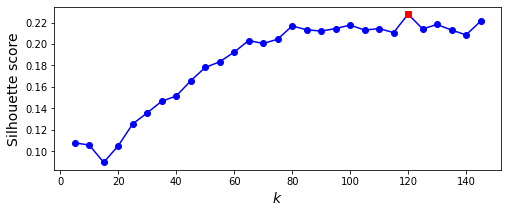

In [103]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [104]:
best_k

120

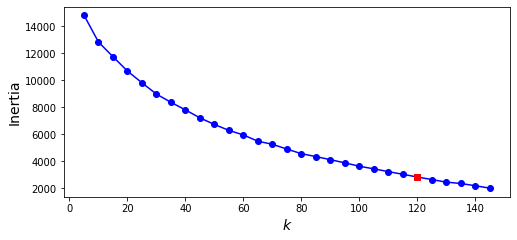

In [105]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

In [106]:
best_model = kmeans_per_k[best_index]

Cluster 0


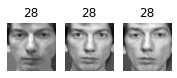

Cluster 1


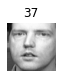

Cluster 2


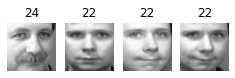

Cluster 3


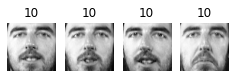

Cluster 4


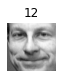

Cluster 5


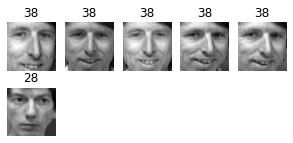

Cluster 6


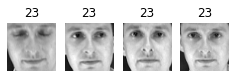

Cluster 7


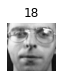

Cluster 8


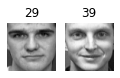

Cluster 9


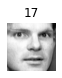

Cluster 10


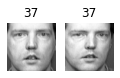

Cluster 11


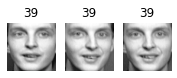

Cluster 12


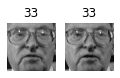

Cluster 13


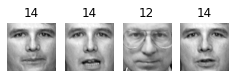

Cluster 14


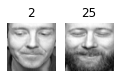

Cluster 15


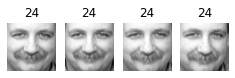

Cluster 16


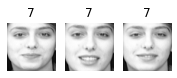

Cluster 17


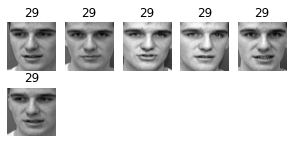

Cluster 18


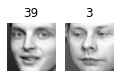

Cluster 19


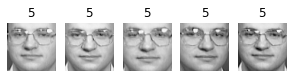

Cluster 20


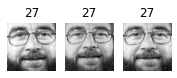

Cluster 21


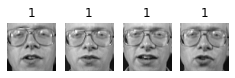

Cluster 22


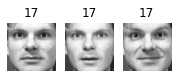

Cluster 23


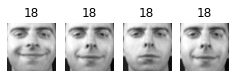

Cluster 24


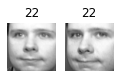

Cluster 25


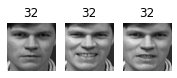

Cluster 26


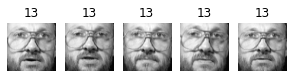

Cluster 27


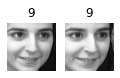

Cluster 28


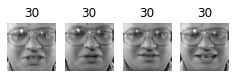

Cluster 29


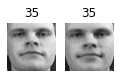

Cluster 30


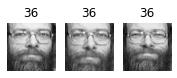

Cluster 31


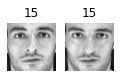

Cluster 32


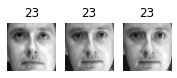

Cluster 33


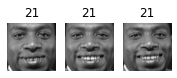

Cluster 34


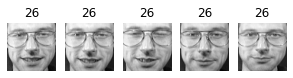

Cluster 35


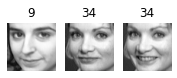

Cluster 36


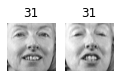

Cluster 37


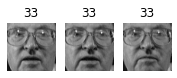

Cluster 38


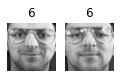

Cluster 39


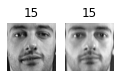

Cluster 40


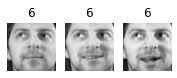

Cluster 41


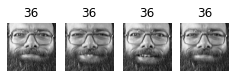

Cluster 42


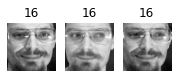

Cluster 43


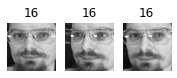

Cluster 44


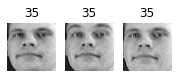

Cluster 45


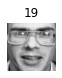

Cluster 46


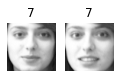

Cluster 47


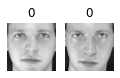

Cluster 48


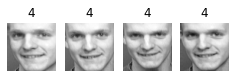

Cluster 49


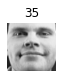

Cluster 50


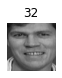

Cluster 51


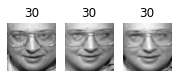

Cluster 52


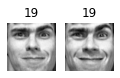

Cluster 53


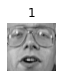

Cluster 54


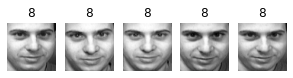

Cluster 55


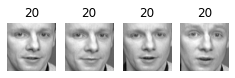

Cluster 56


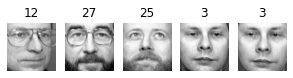

Cluster 57


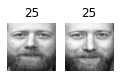

Cluster 58


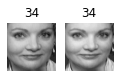

Cluster 59


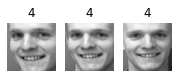

Cluster 60


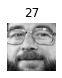

Cluster 61


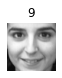

Cluster 62


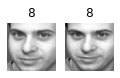

Cluster 63


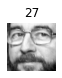

Cluster 64


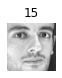

Cluster 65


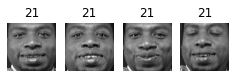

Cluster 66


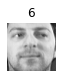

Cluster 67


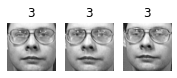

Cluster 68


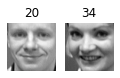

Cluster 69


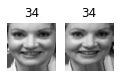

Cluster 70


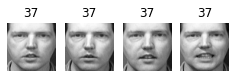

Cluster 71


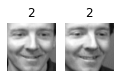

Cluster 72


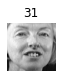

Cluster 73


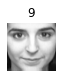

Cluster 74


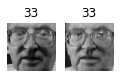

Cluster 75


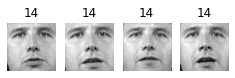

Cluster 76


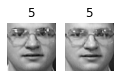

Cluster 77


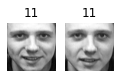

Cluster 78


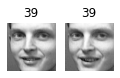

Cluster 79


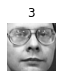

Cluster 80


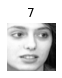

Cluster 81


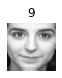

Cluster 82


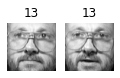

Cluster 83


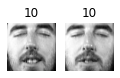

Cluster 84


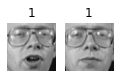

Cluster 85


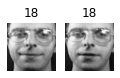

Cluster 86


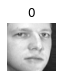

Cluster 87


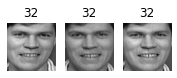

Cluster 88


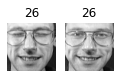

Cluster 89


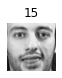

Cluster 90


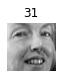

Cluster 91


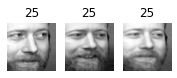

Cluster 92


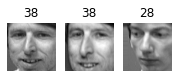

Cluster 93


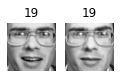

Cluster 94


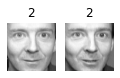

Cluster 95


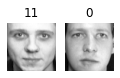

Cluster 96


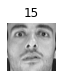

Cluster 97


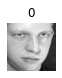

Cluster 98


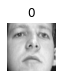

Cluster 99


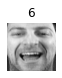

Cluster 100


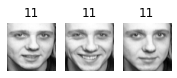

Cluster 101


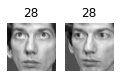

Cluster 102


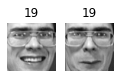

Cluster 103


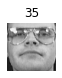

Cluster 104


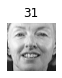

Cluster 105


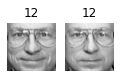

Cluster 106


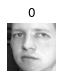

Cluster 107


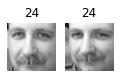

Cluster 108


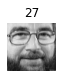

Cluster 109


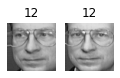

Cluster 110


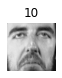

Cluster 111


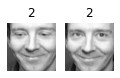

Cluster 112


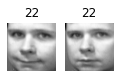

Cluster 113


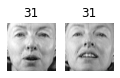

Cluster 114


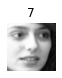

Cluster 115


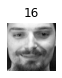

Cluster 116


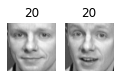

Cluster 117


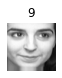

Cluster 118


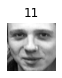

Cluster 119


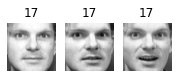

In [107]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

# A Gaussian Mixture Model for the Olivetti Faces Dataset¶


In [108]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

In [109]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

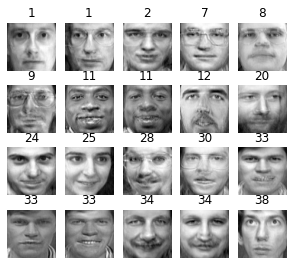

In [110]:
plot_faces(gen_faces, y_gen_faces)

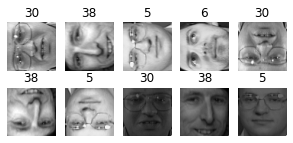

In [111]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [112]:
X_bad_faces_pca = pca.transform(X_bad_faces)


In [113]:
gm.score_samples(X_bad_faces_pca)

array([-2.43643110e+07, -1.89785043e+07, -3.78112108e+07, -4.98187684e+07,
       -3.20479093e+07, -1.37531398e+07, -2.92373880e+07, -1.05488971e+08,
       -1.19575239e+08, -6.74256356e+07])

In [114]:
gm.score_samples(X_train_pca[:10])

array([1163.02020913, 1134.03637757, 1156.3213282 , 1170.67602774,
       1141.45404771, 1154.35205046, 1091.3289437 , 1111.41149389,
       1096.43048794, 1132.98982592])

# Using Dimensionality Reduction Techniques for Anomaly Detection

In [115]:
X_train_pca

array([[ 3.78082347e+00, -1.85479248e+00, -5.14403629e+00, ...,
        -1.35631904e-01, -2.14083940e-01,  6.11892231e-02],
       [ 1.01488562e+01, -1.52754772e+00, -7.66965568e-01, ...,
         1.23926833e-01, -1.35262579e-01, -2.32606847e-02],
       [-1.00152912e+01,  2.87729216e+00, -9.19882417e-01, ...,
         7.26157725e-02, -2.96338997e-03,  1.24889754e-01],
       ...,
       [ 2.47587085e+00,  2.95597053e+00,  1.29985607e+00, ...,
        -2.09053084e-02,  3.48560028e-02, -1.54327497e-01],
       [-3.22031403e+00,  5.34898043e+00,  1.39426959e+00, ...,
         5.75501136e-02, -2.28312939e-01,  1.55562788e-01],
       [-9.22877252e-01, -3.64703059e+00,  2.26088047e+00, ...,
         1.36848077e-01, -6.91322759e-02,  6.26963675e-02]], dtype=float32)

In [116]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [117]:
reconstruction_errors(pca, X_train).mean()

0.0001920535

In [118]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

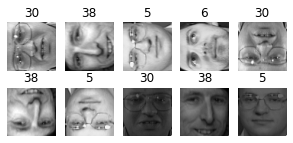

In [119]:
plot_faces(X_bad_faces, y_bad)

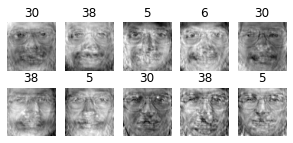

In [120]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)